In [1]:
# 일반
import numpy as np
import pandas as pd
import nltk, random, os
from os import path
from PIL import Image

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

# 한글설정
plt.rcParams['font.family'] = 'NanumGothic'
# sns.set(font_scale = 1)

# 그래프 테마
sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
])

# 전처리
import string, re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# 모델링
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec

# 경고무시
import  warnings
warnings.filterwarnings('ignore')

모듈은 5가지로 나눔

- 일반: numpy, pandas, NLTK(자연어처리), os(경로 가져오기), PIL(이미지 저장)
- 시각화: matplotlib, seaborn, wordcloud
- 전처리
- 모델링
- 경고무시

# 1. 데이터 정보

## 1-1. 데이터 기본 정보

In [2]:
# 데이터 로드 및 정리
df = pd.read_csv("/home/lab543/jupyter/jinyoung/data/Womens Clothing E-Commerce Reviews.csv")
df.drop(df.columns[0], inplace = True, axis = 1)

# 결측치 처리
for x in ['Division Name','Department Name','Class Name','Review Text']:
    df = df[df[x].notnull()]
    
# 컬럼 유일값 및 결측치 수
unique_count = []
for x in df.columns:
    unique_count.append([x, len(df[x].unique()), df[x].isnull().sum()])

# 파생변수 생성
df["Word Count"] = df["Review Text"].str.split().apply(len)
df["Character Count"] = df["Review Text"].apply(len)
df["Label"] = 0
df.loc[df.Rating >= 3, ["Label"]] = 1 #긍부정

# 결측치 수
print("결측치가 있는 행 수: {}".format(df.isnull().sum().sum()))
print("데이터 dimension: {} 행수, {} 컬럼수".format(*df.shape))

결측치가 있는 행 수: 2966
데이터 dimension: 22628 행수, 13 컬럼수


In [3]:
df.sample(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count,Character Count,Label
12328,1060,30,NaN,"These looked so fun, i had to have them! i usu...",5,1,0,General Petite,Bottoms,Pants,57,300,1
5805,1025,37,Awkward,"The fabric is absolutely lovely on these, but ...",3,0,3,General,Bottoms,Jeans,97,499,1
4058,860,37,Black or grey?,This is a great shirt. the ruffles are strateg...,4,1,0,General Petite,Tops,Knits,50,279,1


- Title: 제목
- Review Text: 리뷰내용
- Rating: 평점
- Recommended IND: 추천 여부
- Positive Feedback Count: Number of positive feedback on the review
- Division Name: Name of the division product is in
- Department Name: Name of the department product is in
- Class Name: Type of product
- Label: 평점 3 이상은 1

In [4]:
pd.DataFrame(unique_count, columns = ["컬럼","유일값","결측치"]).set_index('컬럼').T

컬럼,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
유일값,1172,77,13984,22621,5,2,82,3,6,20
결측치,0,0,2966,0,0,0,0,0,0,0


---

## 1-2. 데이터 분포

### 1)수치 데이터

In [5]:
df.describe().T.drop('count',axis=1)

,mean,std,min,25%,50%,75%,max
Clothing ID,919.695908,201.683804,1.0,861.0,936.0,1078.0,1205.0
Age,43.282880,12.328176,18.0,34.0,41.0,52.0,99.0
Rating,4.183092,1.115911,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.818764,0.385222,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.631784,5.787520,0.0,0.0,1.0,3.0,122.0
Word Count,60.211950,28.533053,2.0,36.0,59.0,88.0,115.0
Character Count,308.761534,143.934126,9.0,186.0,302.0,459.0,508.0
Label,0.895263,0.306222,0.0,1.0,1.0,1.0,1.0


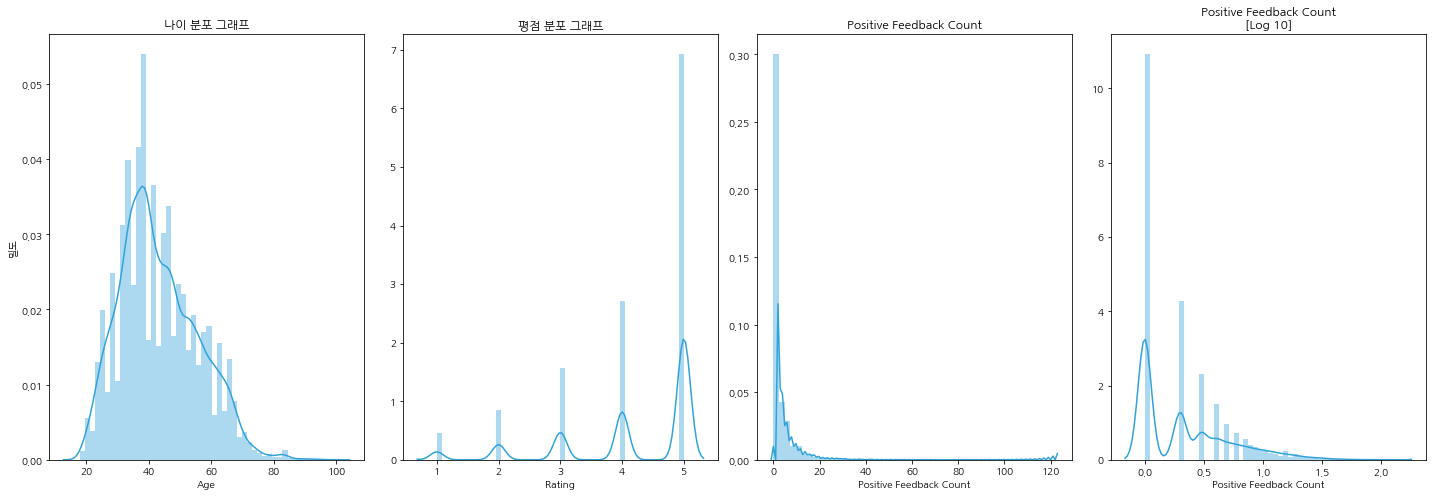

In [6]:
# plt.rcParams['font.family'] = 'NanumGothic'

f, ax = plt.subplots(1,4, figsize = (20,7),sharey = False)
sns.distplot(df.Age, ax=ax[0])
ax[0].set_title("나이 분포 그래프")
ax[0].set_ylabel("밀도")
sns.distplot(df.Rating, ax=ax[1])
ax[1].set_title("평점 분포 그래프")
sns.distplot(df["Positive Feedback Count"], ax=ax[2])
ax[2].set_title("Positive Feedback Count")
sns.distplot(np.log10((df["Positive Feedback Count"][df["Positive Feedback Count"].notnull()]+1)), ax=ax[3])
ax[3].set_title("Positive Feedback Count\n[Log 10]")
plt.tight_layout()
plt.show()

- 평균 나이 약 43세, 최소 나이 18세, 최대 나이 99세로, 40대가 많아 연령대가 어리진 않음
- 평균 평점 약 4.2, 5점대가 가장 많음
- positive feedback 그래프가 왼쪽으로 치우침, 상위권이 전체를 대변할 것으로 판단(파레토 법칙) 

### 2)텍스트 데이터

In [7]:
df[["Title", "Division Name","Department Name","Class Name"]].describe().T.drop("count",axis=1)

,unique,top,freq
Title,13983,Love it!,136
Division Name,3,General,13365
Department Name,6,Tops,10048
Class Name,20,Dresses,6145


### 3)Positive Feedback Count

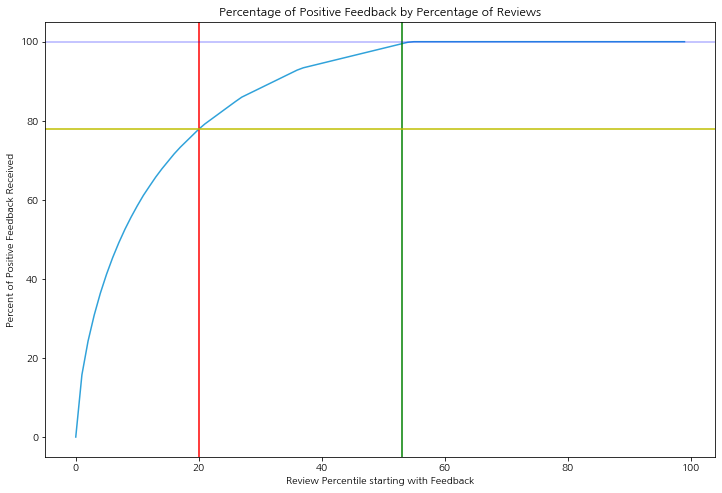

Positive Feedback에서 상위 20%가 전체의 78.0%를 차지

지니계수: 0.76


In [8]:
# 상위 몇 프로가 전체의 얼마나 차지하는지 
def percentage_accumulation(series, percentage):
    return (series.sort_values(ascending = False)
           [:round(series.shape[0]*(percentage/100))]
           .sum()/series
           .sum()*100)

# 지니계수 - 불평등 정도를 나타내는 계수
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

# Cumulative Percentage of Positive Feedback assigned Percent of Reviewers (from most wealthy)
inequality = []
for x in list(range(100)):
    inequality.append(percentage_accumulation(df["Positive Feedback Count"], x))
    
# 그래프
plt.figure(figsize = (12,8))
plt.plot(inequality)
plt.title("Percentage of Positive Feedback by Percentage of Reviews")
plt.xlabel("Review Percentile starting with Feedback")
plt.ylabel("Percent of Positive Feedback Received")
plt.axvline(x=20, c = "r")
plt.axvline(x=53, c = "g")
plt.axhline(y=78, c = "y")
plt.axhline(y=100, c = "b", alpha=.3)
plt.show()

# 파레토 법칙 확인
print("Positive Feedback에서 상위 20%가 전체의 {}%를 차지".format(round(percentage_accumulation(df["Positive Feedback Count"],20))))

# 지니계수
print("\n지니계수: {}".format(round(gini(df["Positive Feedback Count"]),2)))

*지니계수::오늘날 가장 널리 사용되는, 불평등의 정도를 나타내는 통계학적 지수, 1로 갈수록 불평등*

상위 20%의 20%를 보자

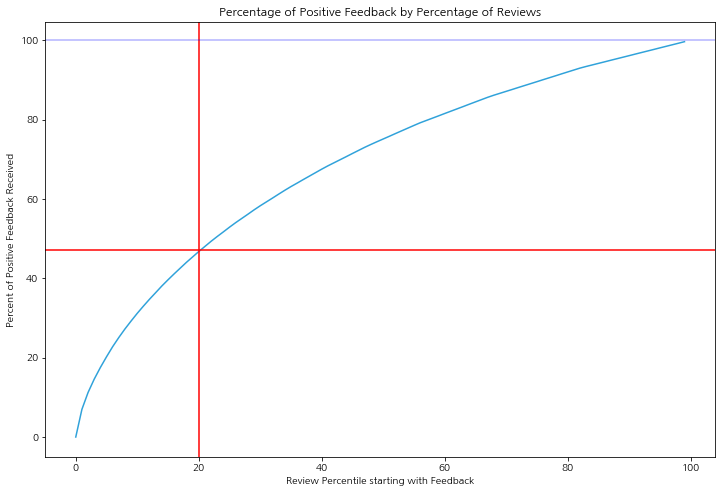

Positive Feedback에서 상위 20%의 상위 20%가 상위 20%의 47.0%를 차지

지니계수: 0.38


In [9]:
top_20 = df["Positive Feedback Count"].sort_values(ascending = False)[:round(df.shape[0]*(20/100))]

inequality = []
for x in list(range(100)):
    inequality.append(percentage_accumulation(top_20,x))
    
# 그래프
plt.figure(figsize = (12,8))
plt.plot(inequality)
plt.title("Percentage of Positive Feedback by Percentage of Reviews")
plt.xlabel("Review Percentile starting with Feedback")
plt.ylabel("Percent of Positive Feedback Received")
plt.axvline(x=20, c = "r")
plt.axhline(y=47, c = "r")
plt.axhline(y=100, c = "b", alpha=.3)

plt.show()

# 파레토 법칙 확인
print("Positive Feedback에서 상위 20%의 상위 20%가 상위 20%의 {}%를 차지".format(round(percentage_accumulation(top_20,20))))

# 지니계수
print("\n지니계수: {}".format(round(gini(top_20),2)))

### 4)Name

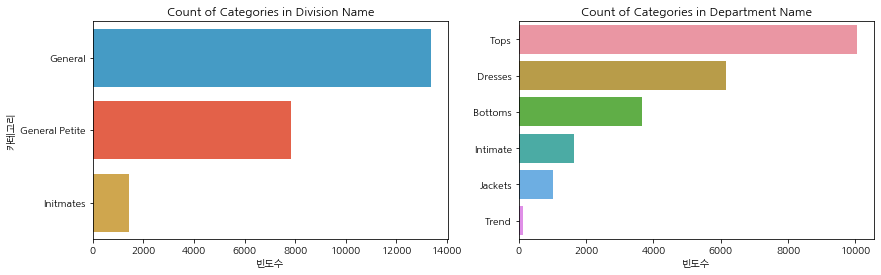

In [10]:
row_plots = ["Division Name","Department Name"]
f, axes = plt.subplots(1,len(row_plots), figsize=(14,4),sharex=False)

for i,x in enumerate(row_plots):
    sns.countplot(y=x, data=df, order=df[x].value_counts().index, ax=axes[i])
    axes[i].set_title("Count of Categories in {}".format(x))
    axes[i].set_xlabel("")
    axes[i].set_xlabel("빈도수")
axes[0].set_ylabel("카테고리")
axes[1].set_ylabel("")

plt.show()

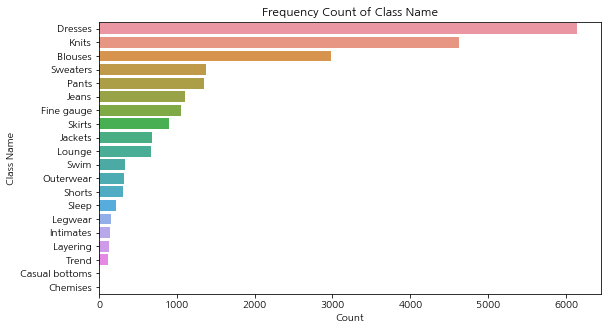

In [11]:
# Class Name
plt.subplots(figsize=(9,5))
sns.countplot(y="Class Name", data=df,order=df["Class Name"].value_counts().index)
plt.title("Frequency Count of Class Name")
plt.xlabel("Count")
plt.show()

### 5)Clothing ID

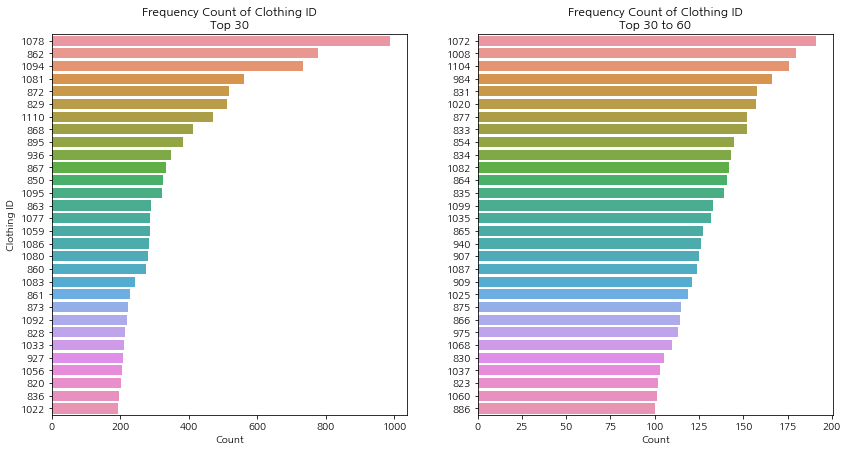

<상위 3개 제품 정보>


,mean,std,min,25%,50%,75%,max
Clothing ID,1015.4848,103.396022,862.0,862.0,1078.0,1094.0,1094.0
Age,42.7248,12.150429,18.0,34.0,41.0,51.0,99.0
Rating,4.1892,1.104306,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.8184,0.385592,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.8624,6.773021,0.0,0.0,1.0,3.0,98.0
Word Count,60.5912,28.731486,2.0,36.0,60.0,89.0,115.0
Character Count,310.8604,144.836158,16.0,189.0,305.0,469.0,504.0
Label,0.9024,0.296832,0.0,1.0,1.0,1.0,1.0


In [12]:
f, axes = plt.subplots(1,2, figsize = [14,7])
num = 30
sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[:num].index)],
             order = df["Clothing ID"].value_counts()[:num].index, ax=axes[0])
axes[0].set_title("Frequency Count of Clothing ID\nTop 30")
axes[0].set_xlabel("Count")

sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[num:60].index)],
              order = df["Clothing ID"].value_counts()[num:60].index,ax=axes[1])
axes[1].set_title("Frequency Count of Clothing ID\nTop 30 to 60")
axes[1].set_ylabel("")
axes[1].set_xlabel("Count")
plt.show()

print("<상위 3개 제품 정보>")
df[df["Clothing ID"].isin([1078, 862,1094])].describe().T.drop("count",axis=1)

In [13]:
df.loc[df["Clothing ID"].isin([1078,862,1094]),["Title","Division Name","Department Name","Class Name"]].describe().T.drop("count",axis = 1)

,unique,top,freq
Title,1815,Beautiful dress,21
Division Name,2,General,1524
Department Name,2,Dresses,1722
Class Name,2,Dresses,1722


### 6) other

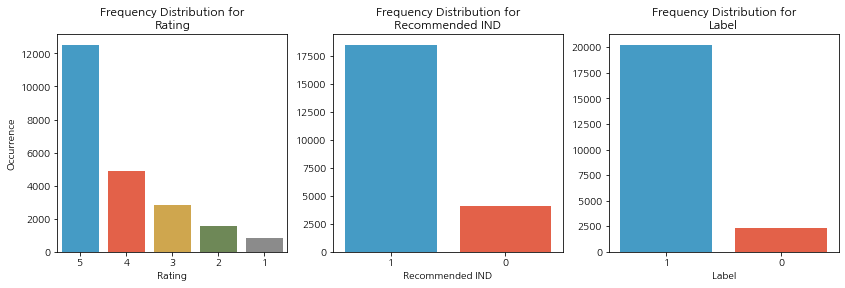

In [14]:
cat_dtypes = ["Rating", "Recommended IND", "Label"]
increment = 0
f, axes = plt.subplots(1,len(cat_dtypes),figsize=(14,4), sharex=False)

for i in range(len(cat_dtypes)):
    sns.countplot(x=cat_dtypes[increment], data = df, order = df[cat_dtypes[increment]].value_counts().index, ax=axes[i])
    axes[i].set_title("Frequency Distribution for\n{}".format(cat_dtypes[increment]))
    axes[i].set_ylabel("Occurrence")
    axes[i].set_xlabel("{}".format(cat_dtypes[increment]))
    increment += 1
axes[1].set_ylabel("")
axes[2].set_ylabel("")
plt.show()

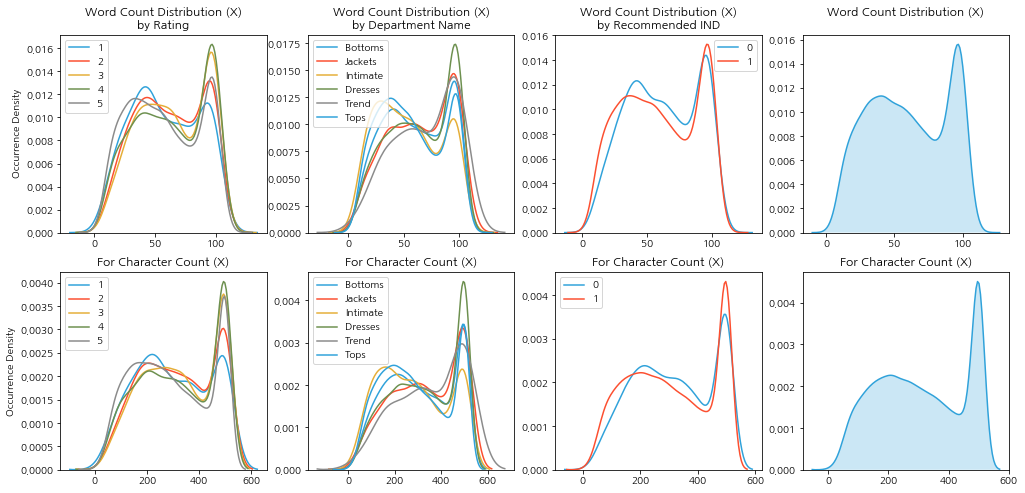

리뷰의 단어 수와 글자 수의 상관계수: 0.99

총 단어 수: 1362476
총 글자 수: 6986656


,count,mean,std,min,25%,50%,75%,max
Word Count,22628.0,60.211950,28.533053,2.0,36.0,59.0,88.0,115.0
Character Count,22628.0,308.761534,143.934126,9.0,186.0,302.0,459.0,508.0


In [15]:
f, axes = plt.subplots(2,4, figsize=(17,8), sharex=False)
for ii, xvar in enumerate(['Word Count', "Character Count"]):
    for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
        for x in set(df[y][df[y].notnull()]):
            sns.kdeplot(df[xvar][df[y]==x], label=x, shade=False, ax=axes[ii,i])
        if ii is 0:
            axes[ii,i].set_title('{} Distribution (X)\nby {}'.format(xvar, y))
        else:
            axes[ii,i].set_title('For {} (X)'.format(xvar))
    axes[ii,0].set_ylabel('Occurrence Density')
    axes[ii,i].set_xlabel('')
    # Plot 4
    sns.kdeplot(df[xvar],shade=True,ax=axes[ii,3])
    axes[ii,3].set_xlabel("")
    if ii is 0:
        axes[ii,3].set_title('{} Distribution (X)\n'.format(xvar))
    else:
        axes[ii,3].set_title('For {} (X)'.format(xvar))
    axes[ii,3].legend_.remove()
plt.show()

print("리뷰의 단어 수와 글자 수의 상관계수: {}".format(
    round(df["Word Count"].corr(df["Character Count"]), 2)))

print("\n총 단어 수: {}".format(df["Word Count"].sum()))
print("총 글자 수: {}".format(df["Character Count"].sum()))
df[["Word Count","Character Count"]].describe().T

- Dresses의 리뷰가 긴 글이 많음

---

# 2.멀티 통계 분석

## 2-1. 범주형 & 범주형

### 1) Division Name & Department Name

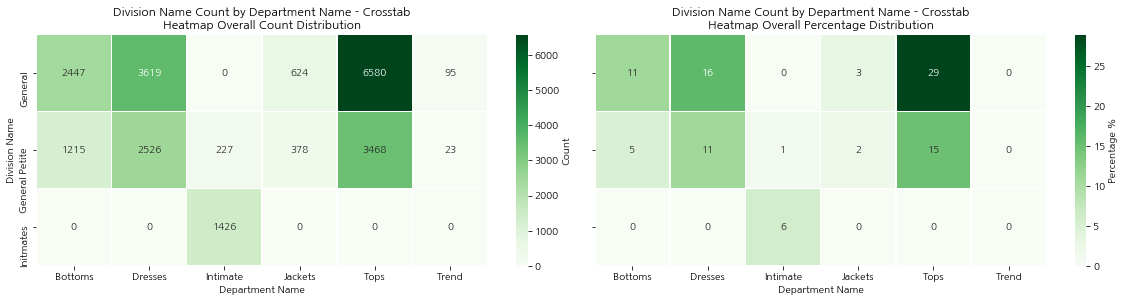

In [16]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(16, 4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"]),
            annot=True, linewidths=.5, ax = ax[0],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Count'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

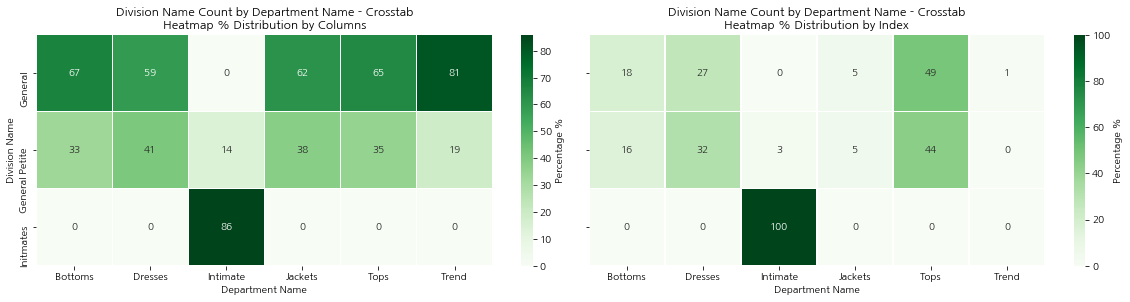

In [17]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(16, 4), sharey=True)

sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize='columns').mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[0],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Columns')

sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize='index').mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Index')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

- 1번 차트: 카운트 수
- 2번 차트: 전체 백분율
- 3번 차트: 컬럼 기준으로 백분율
- 4번 차트: 인덱스 기준으로 백분율

- Tops > Dresses > Bottoms 순으로 리뷰가 많음
- Tops가 압도적으로 많다

### 2) Class Name & Department Name

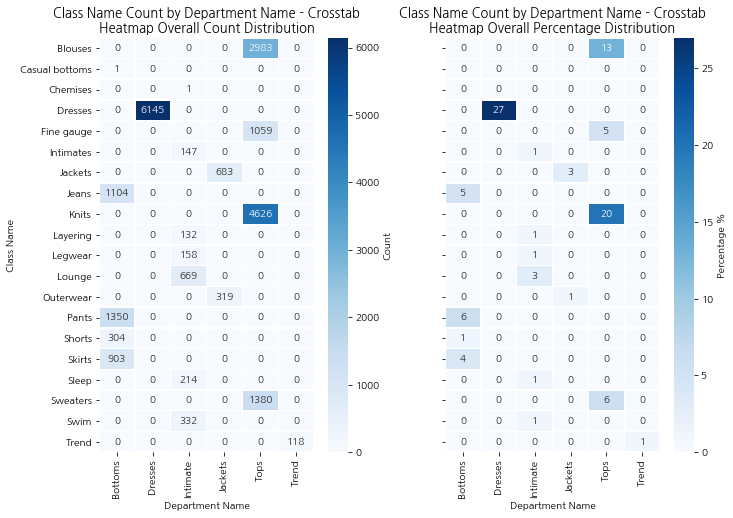

In [18]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(10, 7), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"]),
            annot=True, linewidths=.5, ax = ax[0],fmt='g', cmap="Blues",
                cbar_kws={'label': 'Count'})
ax[0].set_title('Class Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution', fontsize = fsize)

sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Blues",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution', fontsize = fsize)
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

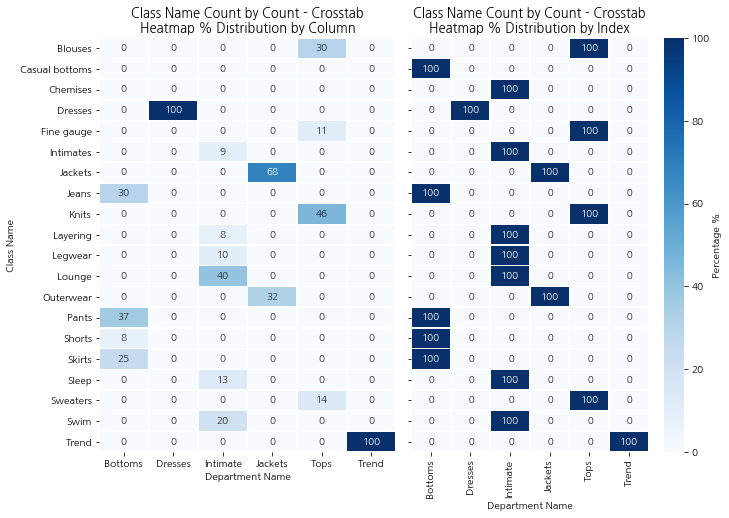

In [19]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(10, 7), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize = 'columns').mul(100).round(0)
            ,annot=True, fmt="g", linewidths=.5, ax=ax[0],cbar=False,cmap="Blues")
ax[0].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Column', fontsize = fsize)
ax[1] = sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize = 'index').mul(100).round(0)
            ,annot=True, fmt="2g", linewidths=.5, ax=ax[1],cmap="Blues",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Index', fontsize = fsize)
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

- 1번 차트: 카운트 수
- 2번 차트: 전체 백분율
- 3번 차트: 컬럼 기준으로 백분율
- 4번 차트: 인덱스 기준으로 백분율

## 2-2. 연속형 & 범주형

### 1)Positive Feedback Count

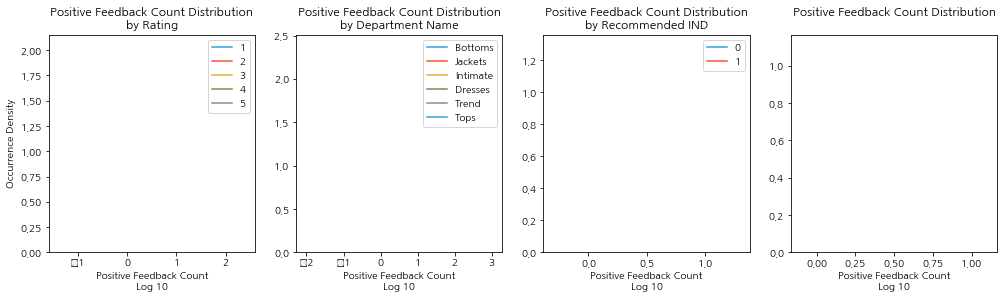

In [20]:
f, axes = plt.subplots(1,4, figsize=(17,4), sharex=False)
xvar = 'Positive Feedback Count'
plotdf = np.log10(df['Positive Feedback Count'])
for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=True, ax=axes[i])
    axes[i].set_xlabel("{}\nLog 10".format(xvar))
    axes[i].set_label('Occurrence Density')
    axes[i].set_title('{} Distribution\nby {}'.format(xvar, y))
axes[0].set_ylabel('Occurrence Density')

sns.kdeplot(plotdf,shade=True,ax=axes[3])
axes[3].set_xlabel("{}\nLog 10".format(xvar))
axes[3].set_title('{} Distribution\n'.format(xvar))
axes[3].legend_.remove()
plt.show()

Recommeded 불평등 살펴보기

In [21]:
for rec in [0,1]:
    temp = df["Positive Feedback Count"][df["Recommended IND"] == rec]

    print("Recommended is {}".format(rec))
    # 80-20 Rule Confirmation
    print("{}% of Positive Feedback belongs to the top 20% of Reviews with Recommeded = {}".format(
        round(percentage_accumulation(temp, 20)),rec))
    # Gini
    print("Gini Coefficient: {}\n".format(round(gini(temp),2)))

Recommended is 0
75.0% of Positive Feedback belongs to the top 20% of Reviews with Recommeded = 0
Gini Coefficient: 0.73

Recommended is 1
78.0% of Positive Feedback belongs to the top 20% of Reviews with Recommeded = 1
Gini Coefficient: 0.76



### 2) Age & other

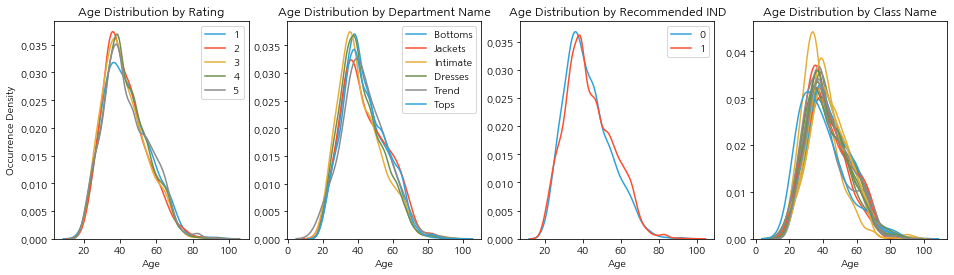

In [22]:
f, axes = plt.subplots(1,4, figsize=(16,4), sharex=False)
xvar = "Age"
plotdf = df["Age"]
for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=False, ax=axes[i])
    axes[i].set_xlabel("{}".format(xvar))
    axes[i].set_label('Occurrence Density')
    axes[i].set_title('{} Distribution by {}'.format(xvar, y))

for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(plotdf[df["Class Name"]==x], label=x, shade=False, ax=axes[3])

axes[3].legend_.remove()
axes[3].set_xlabel('{}'.format(xvar))
axes[0].set_ylabel('Occurrence Density')
axes[3].set_title('{} Distribution by {}'.format(xvar, "Class Name"))
plt.show()

---

## 2-3. 연속형 & 연속형

### 1) Age & Positive Feedback Count

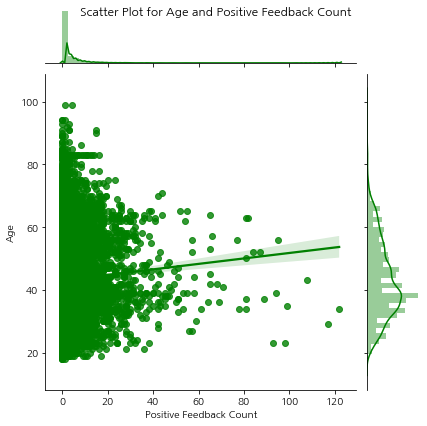

In [23]:
g = sns.jointplot(x=df["Positive Feedback Count"], y=df["Age"],kind='reg',color='g')
g.fig.suptitle("Scatter Plot for Age and Positive Feedback Count")
plt.show()